In [1]:
# Left Off:  Turn some of the continuous items into bins and then examine from there.

In [2]:
# Import all
import numpy as np
import pandas as pd
import numba

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8

## Data Load

In [3]:
# load the data and merge
workingDir = 'D:\\project\\data\\dd_watertable\\'
df_train_x = pd.read_csv(workingDir + 'training_data.csv')
df_train_y = pd.read_csv(workingDir + 'training_label.csv')
df_test_x = pd.read_csv(workingDir + 'test_data.csv')

# Columns to Keep from excel
columnsToKeep = 'id','amount_tsh','date_recorded','funder','gps_height','installer','longitude','latitude','num_private','basin',\
'subvillage','region','region_code','district_code','lga','ward','population','public_meeting','scheme_management','permit','construction_year',\
'extraction_type','management','management_group','payment','quality_group','quantity','source','source_class','waterpoint_type'

df_train_x = df_train_x[list(columnsToKeep)]
df_test_x = df_test_x[list(columnsToKeep)]

# concat
df_train_x = pd.merge(df_train_x, df_train_y, how='inner', on=['id'])
df_train_x.head(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,...,extraction_type,management,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,0,Lake Nyasa,...,gravity,vwc,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,0,Lake Victoria,...,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,0,Pangani,...,gravity,vwc,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,0,Ruvuma / Southern Coast,...,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,0,Lake Victoria,...,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional


In [4]:
# COLUMN DATA TYPE MASSAGING

# Date Recorded
df_train_x['date_recorded'] = df_train_x['date_recorded'].astype('datetime64[ns]')

# Convert to a string - Had issues with keeping as a int (converting over to float)
# not the cleanest work-around, but works
df_train_x['construction_year'] = df_train_x['construction_year'].astype(str)

# Set this to June 1 (chnged to 1-1 becuase of negative vlues)
df_train_x.loc[df_train_x['construction_year'] != '0','construction_year'] = (df_train_x['construction_year'] + '-01-01') #.astype('datetime64[ns]')

# if equal to 0 set to np.nan
df_train_x.loc[df_train_x['construction_year'] == '0','construction_year'] = ''

# convert to datetime
df_train_x['construction_year'] = df_train_x['construction_year'].astype('datetime64[ns]')

In [5]:
df_train_x.head(10)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,...,extraction_type,management,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,0,Lake Nyasa,...,gravity,vwc,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,0,Lake Victoria,...,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,0,Pangani,...,gravity,vwc,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,0,Ruvuma / Southern Coast,...,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,0,Lake Victoria,...,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,0,Pangani,...,submersible,vwc,user-group,pay per bucket,salty,enough,other,unknown,communal standpipe multiple,functional
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,0,Internal,...,swn 80,vwc,user-group,never pay,good,enough,machine dbh,groundwater,hand pump,non functional
7,54551,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,0,Lake Tanganyika,...,nira/tanira,wug,user-group,unknown,milky,enough,shallow well,groundwater,hand pump,non functional
8,53934,0.0,2012-11-03,Wateraid,0,Water Aid,32.711100,-5.146712,0,Lake Tanganyika,...,india mark ii,vwc,user-group,never pay,salty,seasonal,machine dbh,groundwater,hand pump,non functional
9,46144,0.0,2011-08-03,Isingiro Ho,0,Artisan,30.626991,-1.257051,0,Lake Victoria,...,nira/tanira,vwc,user-group,never pay,good,enough,shallow well,groundwater,hand pump,functional


In [6]:
df_train_x['construction_year'][1]
df_train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 31 columns):
id                   59400 non-null int64
amount_tsh           59400 non-null float64
date_recorded        59400 non-null datetime64[ns]
funder               55765 non-null object
gps_height           59400 non-null int64
installer            55745 non-null object
longitude            59400 non-null float64
latitude             59400 non-null float64
num_private          59400 non-null int64
basin                59400 non-null object
subvillage           59029 non-null object
region               59400 non-null object
region_code          59400 non-null int64
district_code        59400 non-null int64
lga                  59400 non-null object
ward                 59400 non-null object
population           59400 non-null int64
public_meeting       56066 non-null object
scheme_management    55523 non-null object
permit               56344 non-null object
construction_year    38691

##  FEATURE ENGINEERING

In [7]:
# Number of months since the well was built
from datetime import datetime

def diff_month(cols):
    d1 = cols[0]
    d2 = cols[1]
    
    if d1 == np.datetime64('NaT') or d2 == np.datetime64('NaT'):
        return 0
    else:
        return (d1.year - d2.year) * 12 + d1.month - d2.month

# Assign
df_train_x['ft_monthsSinceBuild'] = df_train_x[['date_recorded','construction_year']].apply(diff_month,axis=1)

## PLOTTING

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

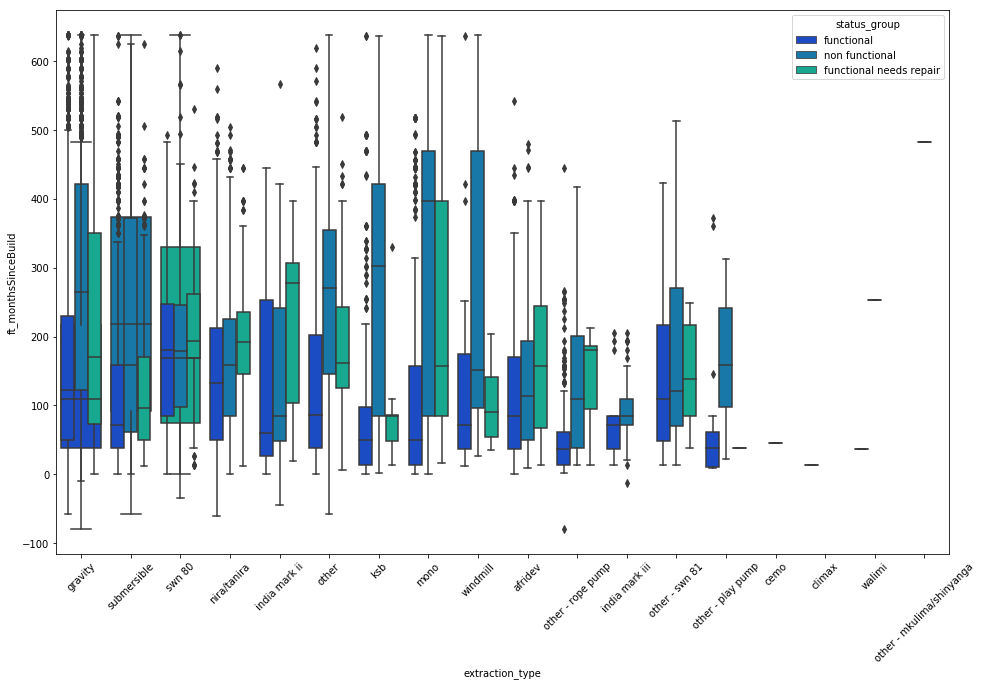

In [36]:
plt.figure(figsize=(16, 10))
sns.boxplot(x='status_group',y='ft_monthsSinceBuild',data=df_train_x,palette='winter')
sns.boxplot(x='extraction_type',y='ft_monthsSinceBuild',data=df_train_x,palette='winter', hue='status_group')
plt.xticks(rotation=45)
#sns.boxplot(x='extraction_type',y='ft_monthsSinceBuild',data=df_train_x,palette='winter')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124]),
 <a list of 125 Text xticklabel objects>)

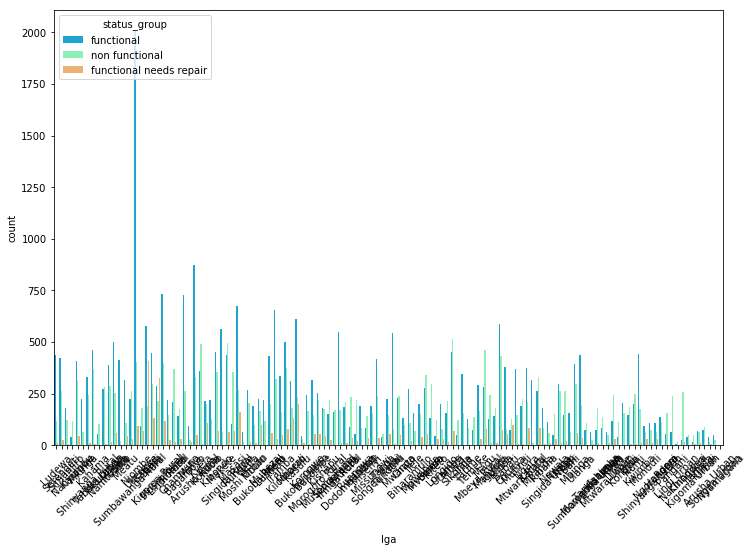

In [37]:
#sns.countplot(x='basin', hue='status_group', data=df_train_x, palette='rainbow')
#sns.countplot(x='region', hue='status_group', data=df_train_x, palette='rainbow')
sns.countplot(x='lga', hue='status_group', data=df_train_x, palette='rainbow')
plt.xticks(rotation=45)
#(df_train_x[['funder']], hue='status_group', kind='dist')

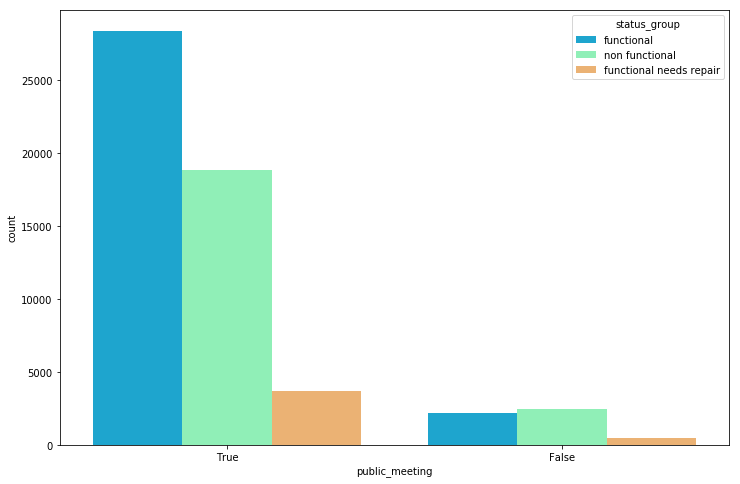

In [10]:
sns.countplot(x='public_meeting', hue='status_group', data=df_train_x, palette='rainbow')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

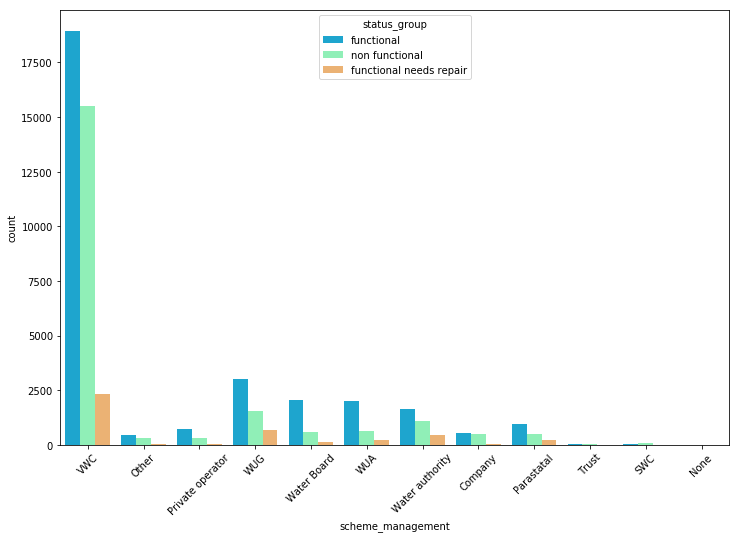

In [38]:
sns.countplot(x='scheme_management', hue='status_group', data=df_train_x, palette='rainbow')
plt.xticks(rotation=45)

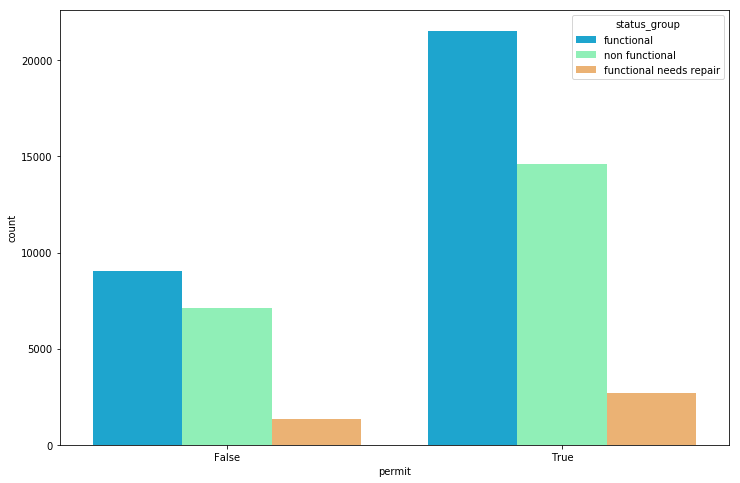

In [12]:
sns.countplot(x='permit', hue='status_group', data=df_train_x, palette='rainbow')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

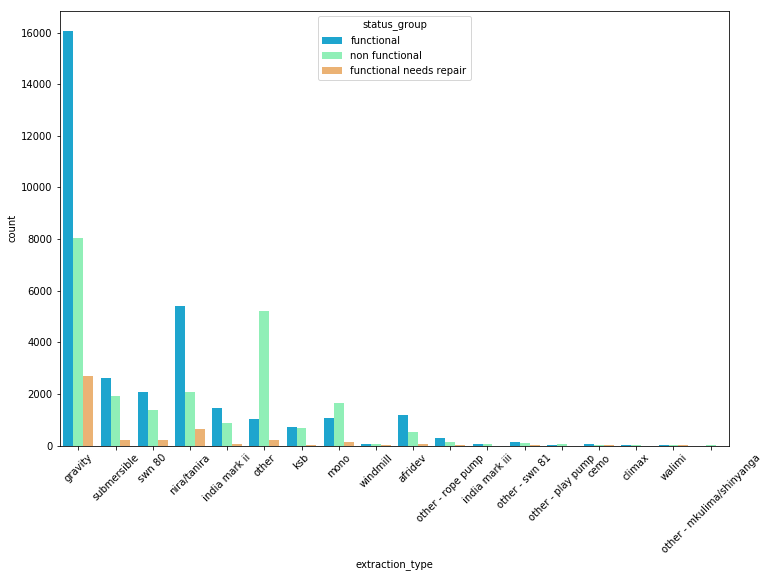

In [39]:
# good candidate to include
sns.countplot(x='extraction_type', hue='status_group', data=df_train_x, palette='rainbow')
plt.xticks(rotation=45)

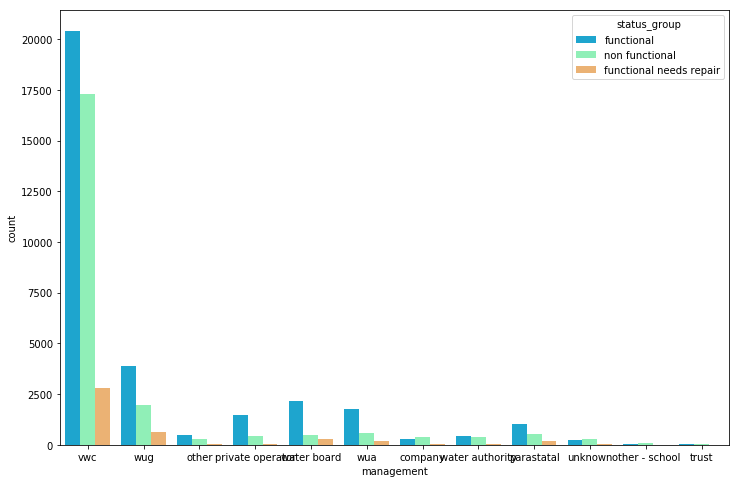

In [14]:
sns.countplot(x='management', hue='status_group', data=df_train_x, palette='rainbow')

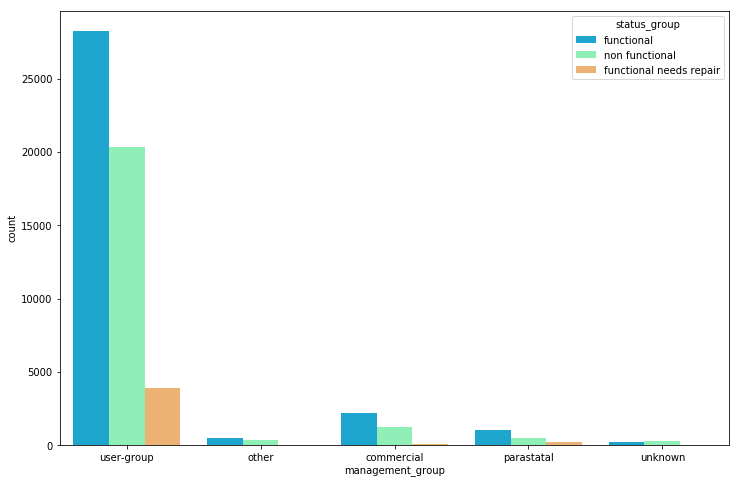

In [15]:
sns.countplot(x='management_group', hue='status_group', data=df_train_x, palette='rainbow')

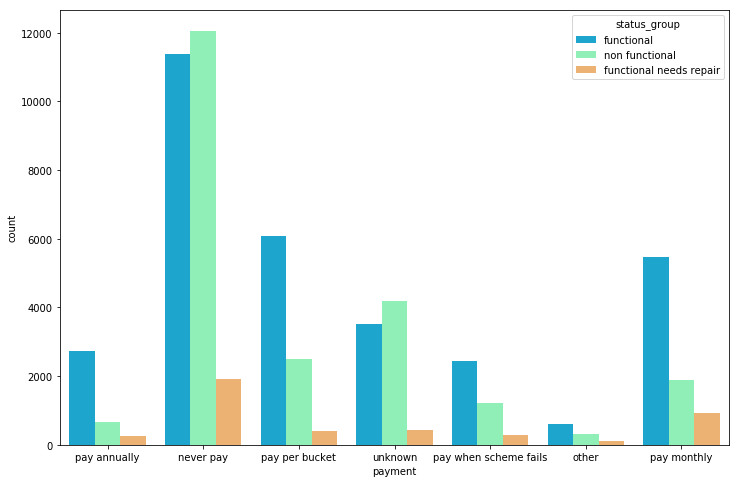

In [16]:
sns.countplot(x='payment', hue='status_group', data=df_train_x, palette='rainbow')

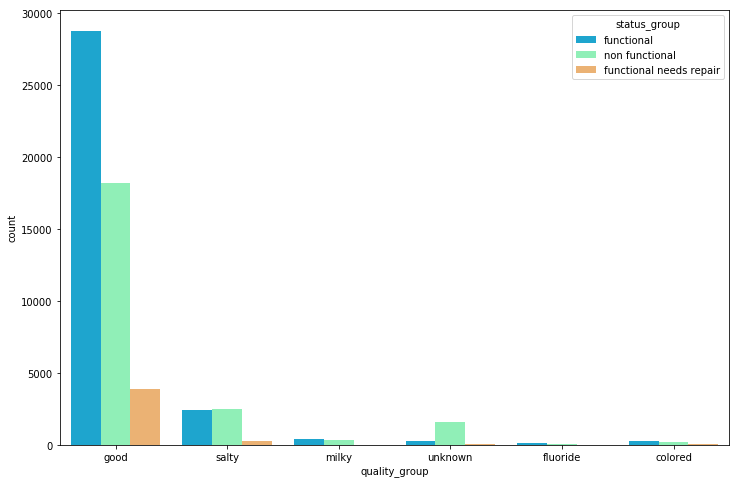

In [17]:
sns.countplot(x='quality_group', hue='status_group', data=df_train_x, palette='rainbow')

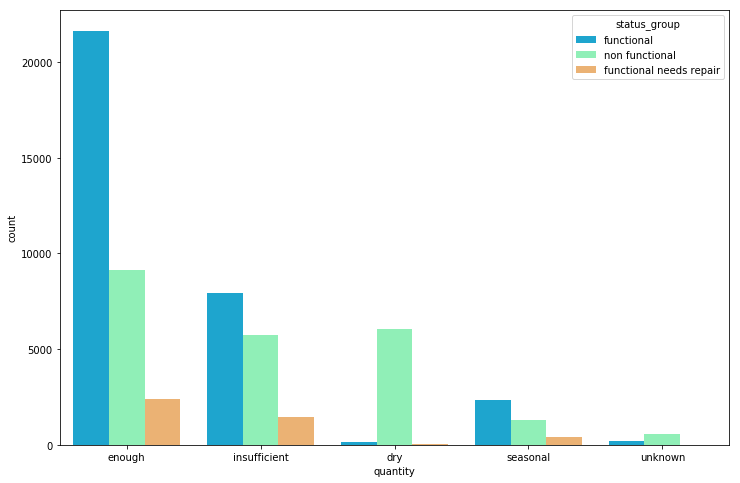

In [18]:
## Looks good to include
sns.countplot(x='quantity', hue='status_group', data=df_train_x, palette='rainbow')

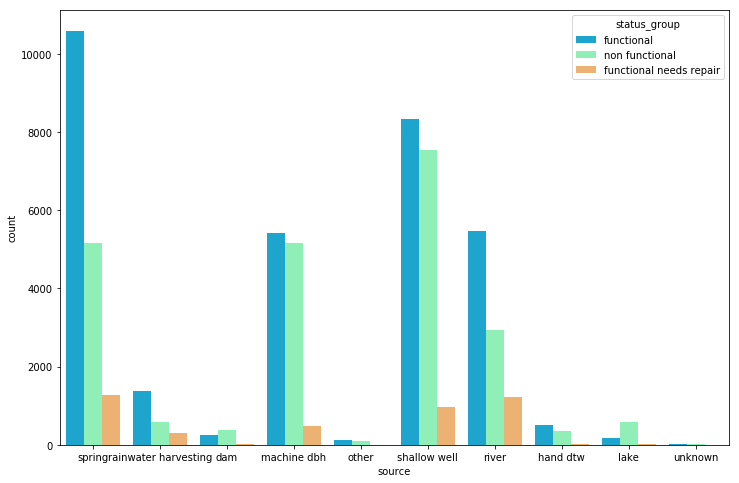

In [19]:
## Looks good to include
sns.countplot(x='source', hue='status_group', data=df_train_x, palette='rainbow')

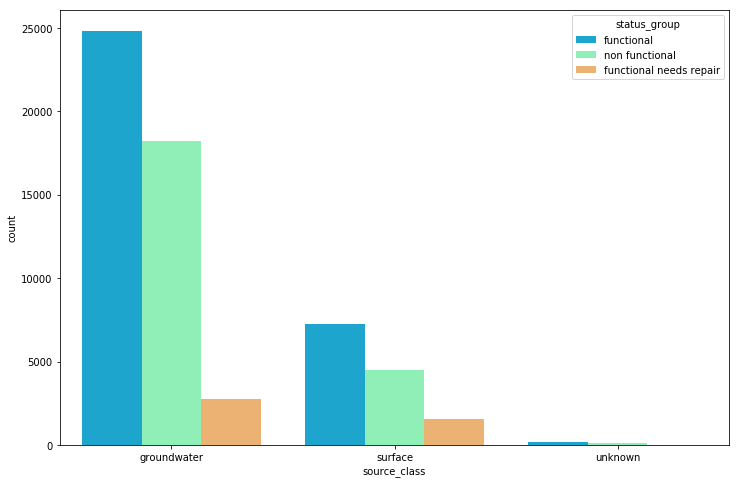

In [20]:
sns.countplot(x='source_class', hue='status_group', data=df_train_x, palette='rainbow')

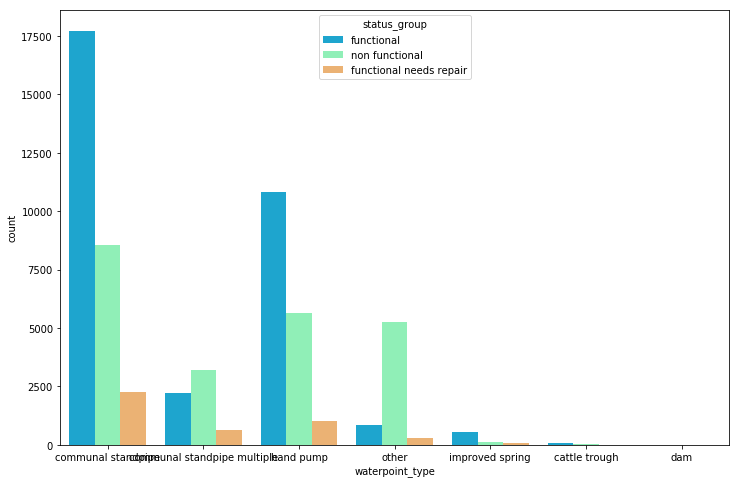

In [21]:
## Looks good to include
sns.countplot(x='waterpoint_type', hue='status_group', data=df_train_x, palette='rainbow')
plt.xticks(rotation=45)

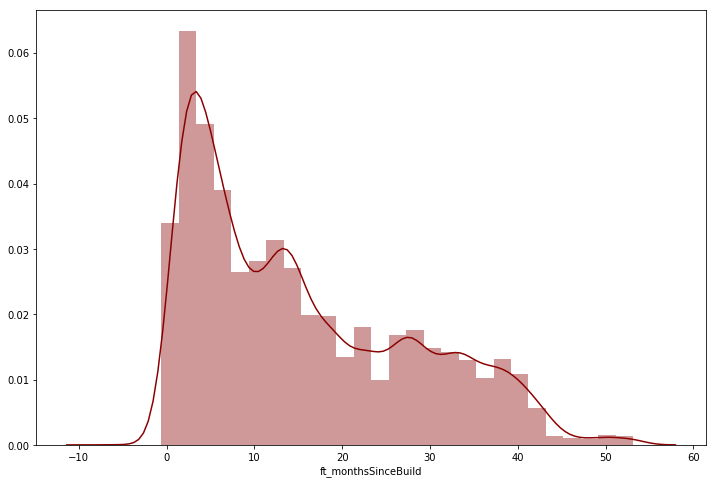

In [22]:
# months
#sns.distplot(df_train_x['ft_monthsSinceBuild'].dropna(),kde=True,color='darkred',bins=30)

# year
sns.distplot(df_train_x['ft_monthsSinceBuild'].dropna()/12,kde=True,color='darkred',bins=30)

In [23]:
# perhaps I need to bin this with month
# ft_monthsSinceBuild

# some good ones with numbers
# amount_tsh
# ft_monthsSinceBuild
# gps_height

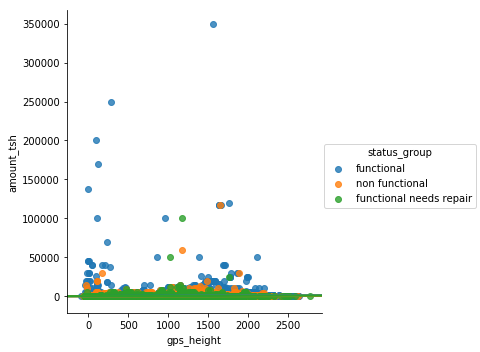

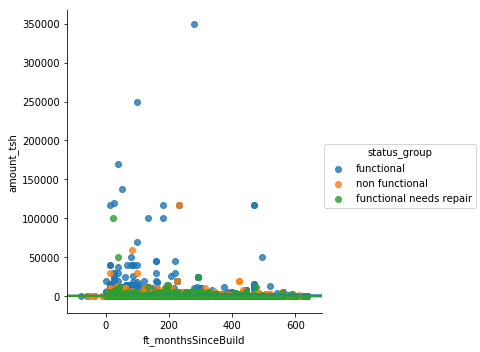

In [24]:
sns.lmplot(x='gps_height',y='amount_tsh', data=df_train_x, hue='status_group', )
sns.lmplot(x='ft_monthsSinceBuild',y='amount_tsh', data=df_train_x, hue='status_group')
# Perhaps explore this as a feature a little bit more

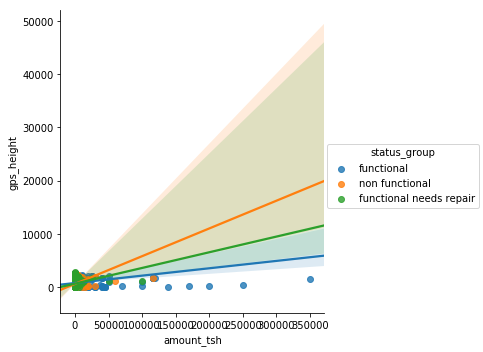

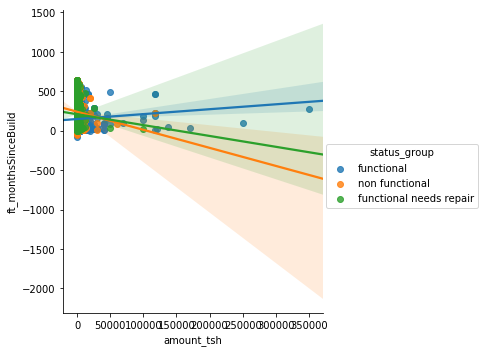

In [25]:
# Reverse axis
sns.lmplot(y='gps_height',x='amount_tsh', data=df_train_x, hue='status_group', )
sns.lmplot(y='ft_monthsSinceBuild',x='amount_tsh', data=df_train_x, hue='status_group')

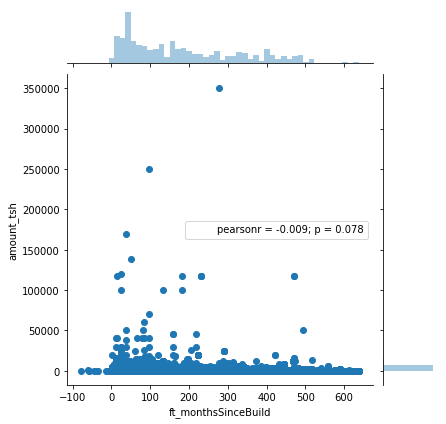

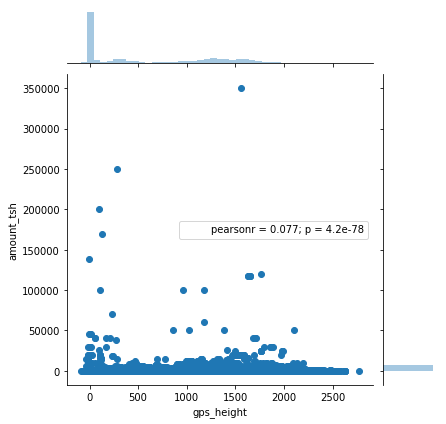

In [26]:
# no relation here
# TODO: Color code
sns.jointplot(x='ft_monthsSinceBuild',y='amount_tsh',data=df_train_x)
sns.jointplot(x='gps_height',y='amount_tsh',data=df_train_x)

In [27]:
# Second Round of plotting

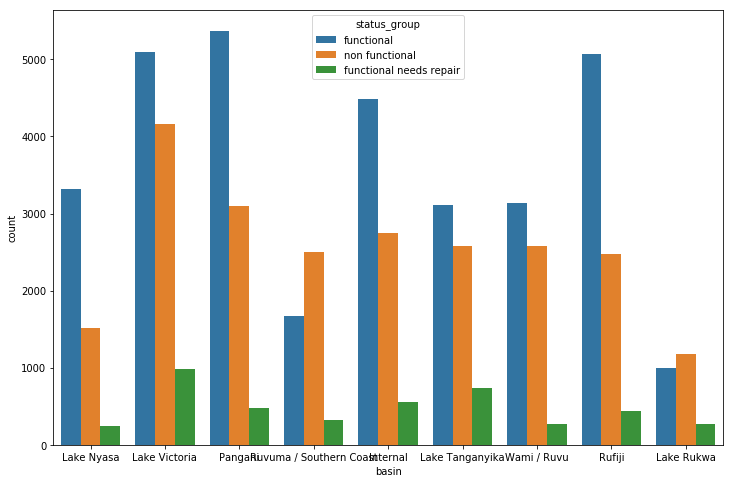

In [28]:
sns.countplot(x='basin', data=df_train_x, hue='status_group')

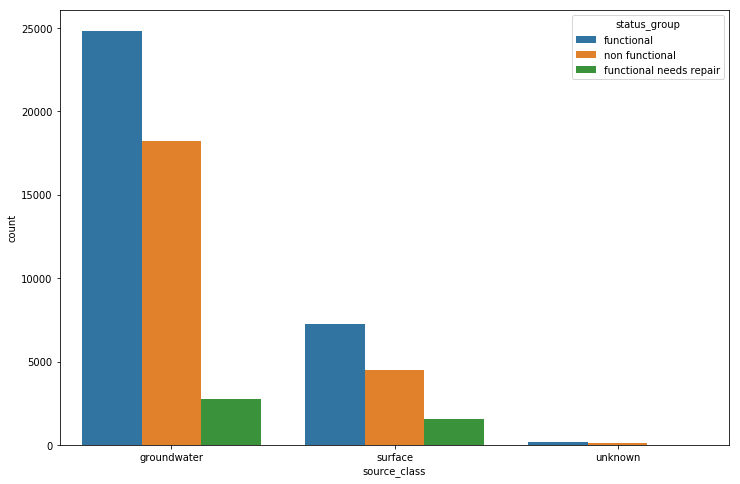

In [29]:
sns.countplot(x='source_class', data=df_train_x, hue='status_group')

In [30]:
df_train_x[df_train_x['amount_tsh']>0]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,...,management,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,status_group,ft_monthsSinceBuild
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,0,Lake Nyasa,...,vwc,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,functional,146.0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,0,Pangani,...,vwc,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,functional,49.0
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,0,Pangani,...,vwc,user-group,pay per bucket,salty,enough,other,unknown,communal standpipe multiple,functional,26.0
11,50409,200.0,2013-02-18,Danida,1062,DANIDA,35.770258,-10.574175,0,Lake Nyasa,...,wug,user-group,pay when scheme fails,good,insufficient,shallow well,groundwater,hand pump,functional,313.0
16,48451,500.0,2011-07-04,Unicef,1703,DWE,34.642439,-9.106185,0,Rufiji,...,wua,user-group,pay monthly,good,dry,river,surface,communal standpipe,non functional,402.0
19,18274,500.0,2011-02-22,Danida,1763,Danid,34.508967,-9.894412,0,Lake Nyasa,...,vwc,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,functional,229.0
20,48375,200.0,2011-02-27,Twe,2216,TWE,34.473430,-9.594990,0,Lake Nyasa,...,vwc,user-group,pay monthly,good,enough,spring,groundwater,communal standpipe,functional,37.0
23,37862,500.0,2013-11-03,Isf,672,ISF,37.940029,-4.125595,0,Pangani,...,vwc,user-group,pay monthly,good,enough,river,surface,communal standpipe,functional,34.0
26,55012,500.0,2013-01-16,Sobodo,200,Kilolo Star,39.370777,-9.942532,0,Ruvuma / Southern Coast,...,vwc,user-group,pay monthly,good,enough,machine dbh,groundwater,hand pump,functional,24.0
31,6696,50.0,2011-03-16,Private Individual,180,WU,38.363555,-6.636104,0,Wami / Ruvu,...,private operator,commercial,pay per bucket,good,enough,river,surface,communal standpipe,functional,86.0


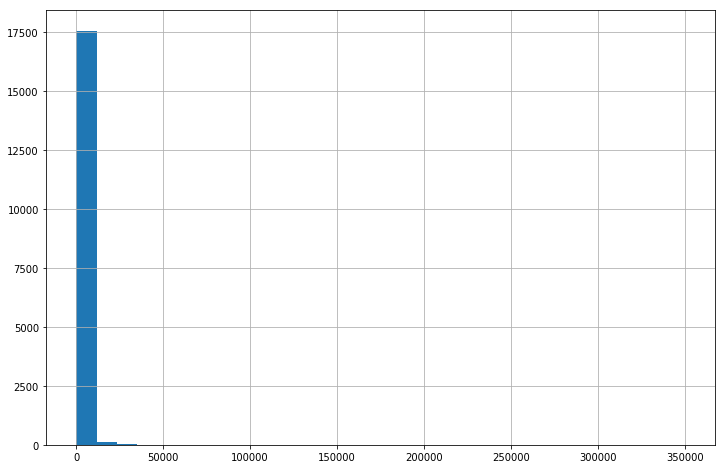

In [31]:
# tsh = water pressure.  Looks pretty centered around 0
df_train_x[df_train_x['amount_tsh']>1]['amount_tsh'].hist(bins=30)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93]),
 <a list of 94 Text xticklabel objects>)

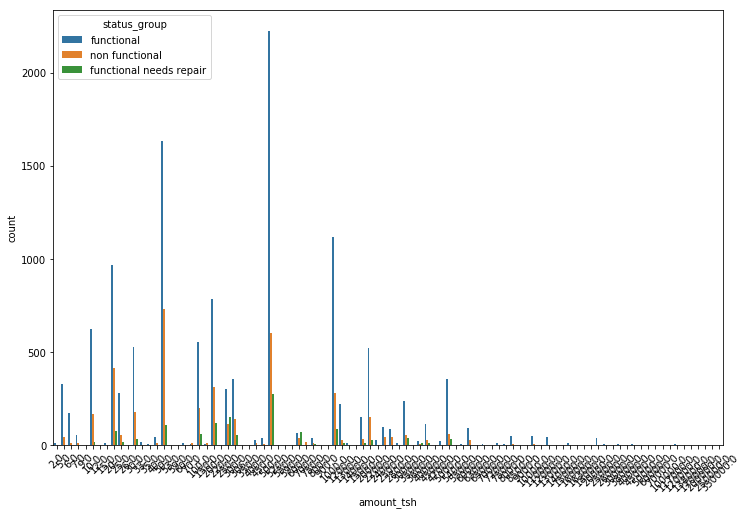

In [40]:
# need to work on this - looks pretty spread out
pos_amount_tsh = df_train_x[df_train_x['amount_tsh']>1]
plt.figsize=(12,8)
sns.countplot(x='amount_tsh', data=pos_amount_tsh, hue='status_group', )
plt.xticks(rotation=45)